In [39]:
import os
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.pipeline import Pipeline
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

In [2]:
dataset_path = '/kaggle/input/plantdisease/PlantVillage'
selected_classes = ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Late_blight', 
                    'Tomato_healthy', 'Tomato_Late_blight']  

data = []
labels = []
# Iterate through the dataset directory
for class_name in os.listdir(dataset_path):
    if class_name in selected_classes:
        class_dir = os.path.join(dataset_path, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            data.append(img_path)
            labels.append(class_name)

df = pd.DataFrame({'data': data, 'label': labels})

In [3]:
df

,data,label
0,/kaggle/input/plantdisease/PlantVillage/Pepper...,Pepper__bell___Bacterial_spot
1,/kaggle/input/plantdisease/PlantVillage/Pepper...,Pepper__bell___Bacterial_spot
2,/kaggle/input/plantdisease/PlantVillage/Pepper...,Pepper__bell___Bacterial_spot
3,/kaggle/input/plantdisease/PlantVillage/Pepper...,Pepper__bell___Bacterial_spot
4,/kaggle/input/plantdisease/PlantVillage/Pepper...,Pepper__bell___Bacterial_spot
...,...,...
6970,/kaggle/input/plantdisease/PlantVillage/Tomato...,Tomato_Late_blight
6971,/kaggle/input/plantdisease/PlantVillage/Tomato...,Tomato_Late_blight
6972,/kaggle/input/plantdisease/PlantVillage/Tomato...,Tomato_Late_blight
6973,/kaggle/input/plantdisease/PlantVillage/Tomato...,Tomato_Late_blight


In [4]:
image = Image.open("/kaggle/input/plantdisease/PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG")
width, height = image.size
print(f"Width: {width}, Height: {height}")

Width: 256, Height: 256


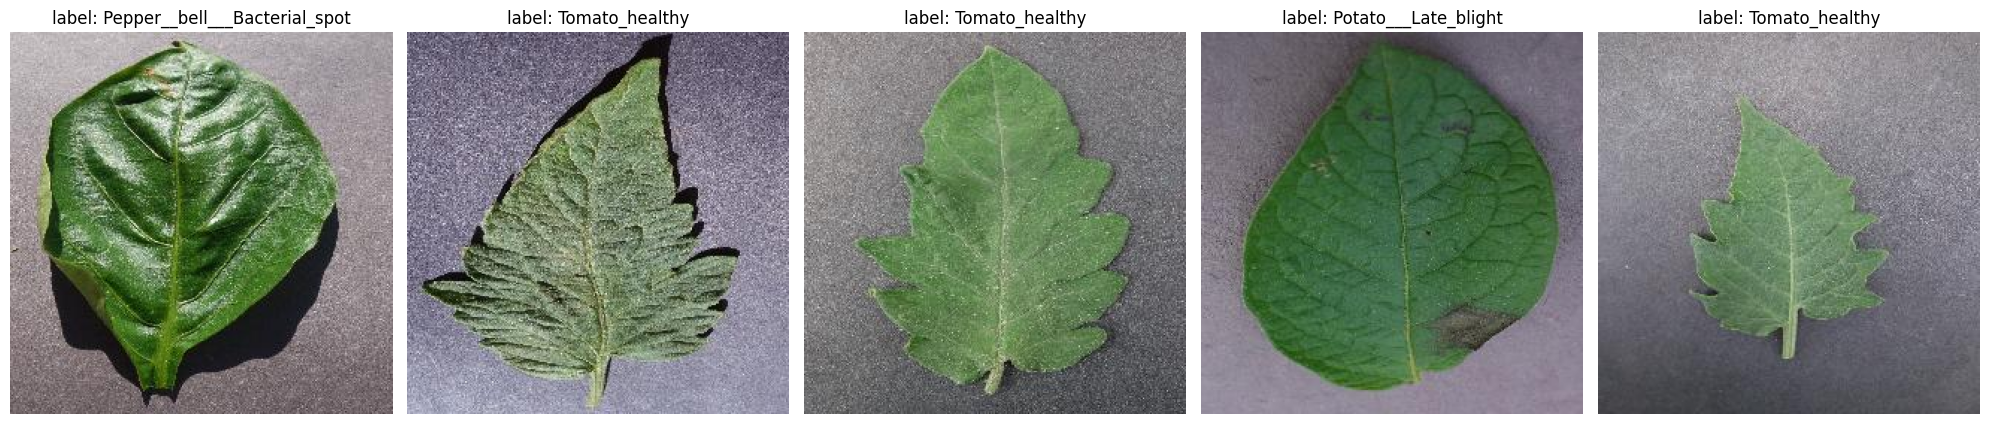

In [28]:
plt.figure(figsize=(20, 15))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    index = np.random.choice(df.index)
    filename = df.loc[index, 'data']
    category = df.loc[index, 'label']
    img = Image.open(filename)
    plt.imshow(img)
    plt.title(f'label: {category}')
    plt.axis('off') 

plt.tight_layout()
plt.show()

In [6]:
def extract_hog_features(image):
    # Convert the image to grayscale using cv2
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    hog = cv2.HOGDescriptor()
    
    # Compute HOG features
    hog_features = hog.compute(gray_image)

    return hog_features.flatten()

In [7]:
df_shuffled = df.sample(frac=1,random_state = 42).reset_index(drop=True)
batch_size = 64
batches = [df_shuffled[i:i+batch_size] for i in range(0, len(df_shuffled), batch_size)]

# Process images in batches
for batch in batches:
    features_list=[]
    labels_list=[]
    for index, row in batch.iterrows():
        image = cv2.imread(row['data'])
        hog_features= extract_hog_features(image)
        features_list.append(hog_features)
        labels_list.append(row['label'])
print("Shape of extracted HOG features:", hog_features.shape)

Shape of extracted HOG features: (1606500,)


In [8]:
# Convert lists to NumPy arrays
features_list = np.array(features_list)
scaler = MinMaxScaler()
features_list = scaler.fit_transform(features_list)
labels_array = np.array(labels_list)
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels_array)

In [9]:
len(numeric_labels)

63

In [10]:
np.unique(numeric_labels)

array([0, 1, 2, 3, 4])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(features_list, numeric_labels, test_size=0.25, random_state=42 , stratify = numeric_labels)

In [12]:
print(type(X_train), X_train.shape)
print(type(y_train), y_train.shape)
print(type(X_test), X_test.shape)
print(type(y_test), y_test.shape)

<class 'numpy.ndarray'> (47, 1606500)
<class 'numpy.ndarray'> (47,)
<class 'numpy.ndarray'> (16, 1606500)
<class 'numpy.ndarray'> (16,)


In [13]:
class_weights = {0: 2.5, 1: 1.5, 2: 0.8 ,3: 0.2 ,4: 0.15} 
lr_pipeline = Pipeline([
    ('pca', PCA(n_components=33,random_state=42)), 
    ('classifier', LogisticRegression(max_iter = 1000,class_weight=class_weights,random_state=42))
])

lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=33, random_state=42)),
                ('classifier',
                 LogisticRegression(class_weight={0: 2.5, 1: 1.5, 2: 0.8,
                                                  3: 0.2, 4: 0.15},
                                    max_iter=1000, random_state=42))])

In [14]:
predictions = lr_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6875


In [15]:
report = classification_report(y_test, predictions, output_dict=True,zero_division=1)

# Convert the report to a pandas DataFrame for better visualization
report = pd.DataFrame(report).transpose()

print(report)

              precision    recall  f1-score  support
0               0.50000  0.333333  0.400000   3.0000
1               1.00000  0.500000  0.666667   4.0000
2               1.00000  1.000000  1.000000   1.0000
3               0.50000  0.750000  0.600000   4.0000
4               0.80000  1.000000  0.888889   4.0000
accuracy        0.68750  0.687500  0.687500   0.6875
macro avg       0.76000  0.716667  0.711111  16.0000
weighted avg    0.73125  0.687500  0.676389  16.0000


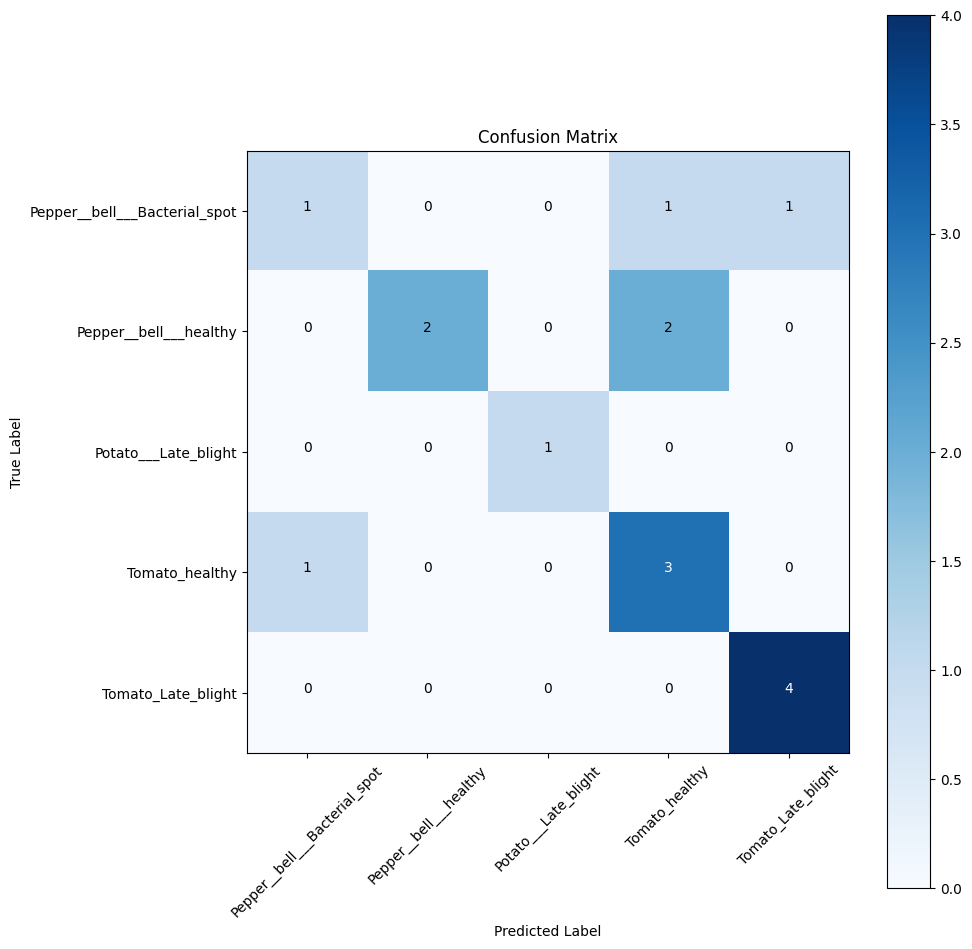

In [16]:
classes = selected_classes


cm = confusion_matrix(y_test, predictions)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')


plt.show()

### K-mean

In [17]:
df

,data,label
0,/kaggle/input/plantdisease/PlantVillage/Pepper...,Pepper__bell___Bacterial_spot
1,/kaggle/input/plantdisease/PlantVillage/Pepper...,Pepper__bell___Bacterial_spot
2,/kaggle/input/plantdisease/PlantVillage/Pepper...,Pepper__bell___Bacterial_spot
3,/kaggle/input/plantdisease/PlantVillage/Pepper...,Pepper__bell___Bacterial_spot
4,/kaggle/input/plantdisease/PlantVillage/Pepper...,Pepper__bell___Bacterial_spot
...,...,...
6970,/kaggle/input/plantdisease/PlantVillage/Tomato...,Tomato_Late_blight
6971,/kaggle/input/plantdisease/PlantVillage/Tomato...,Tomato_Late_blight
6972,/kaggle/input/plantdisease/PlantVillage/Tomato...,Tomato_Late_blight
6973,/kaggle/input/plantdisease/PlantVillage/Tomato...,Tomato_Late_blight


In [18]:
images = [] 
for index2, row2 in df.iterrows():
        image = cv2.imread(row2['data'])
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        images.append(gray_image)

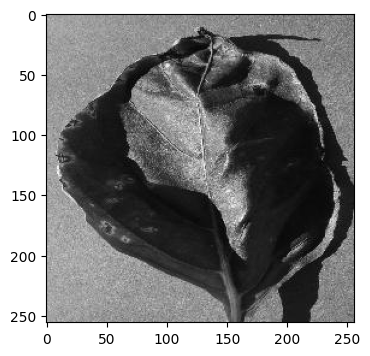

In [19]:
selected_image = images[0]

# Display the image using matplotlib
plt.figure(figsize=(4, 4))
plt.imshow(selected_image, cmap='gray')
plt.show()

In [20]:
print(gray_image.shape)

(256, 256)


In [21]:
images = np.array(images)

In [22]:
len(images)

6975

In [23]:
data = images.reshape((len(images), -1))

In [24]:
data.shape

(6975, 65536)

In [40]:
km = KMeans(n_clusters=5, random_state=42, n_init="auto")

In [41]:
km.fit(data)

KMeans(n_clusters=5, n_init='auto', random_state=42)

In [43]:
cluster_labels = km.labels_

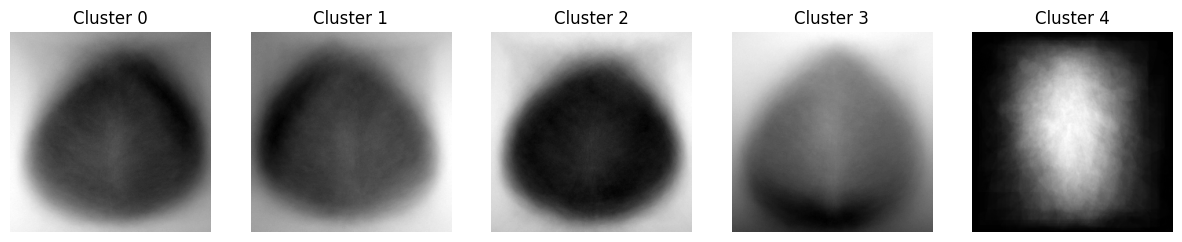

In [52]:
fig, ax = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    center_image = km.cluster_centers_[i].reshape(256, 256)  # Reshape to original dimensions
    ax[i].imshow(center_image, cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f'Cluster {i}')

plt.show()
